<a href="https://colab.research.google.com/github/KOdunga/AIMLCourse/blob/main/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Product Review Sentiment Analysis**

## Goal
- The primary objective is to develop an AI solution that can automatically assess and categorize customer sentiments as negative, positive, or neutral by parsing and analyzing product reviews.

In [1]:
# installing the libraries for transformers
!pip install -U -q sentence-transformers transformers bitsandbytes accelerate sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns

#Deep learning Library
import torch

#Load transformer models
from sentence_transformers import SentenceTransformer
from  transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline

#to split data
from sklearn.model_selection import train_test_split

#to compute perfomance metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#to build a random forest model
from sklearn.ensemble import RandomForestClassifier

#to mute warnings
import warnings
warnings.filterwarnings('ignore')

**Load Dataset**

In [3]:
reviews = pd.read_csv('/content/Product_Reviews.csv')
reviews.head()

,Product ID,Product Review,Sentiment
0,AVpe7AsMilAPnD_xQ78G,"I initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing: the paperwhite is great, but if you have spending money, go for the voyage.Fortunately, I had friends who owned each, so I ended up buying the paperwhite on this basis: both models now have 300 ppi, so the 80 dollar jump turns out pricey the voyage's page press isn't always sensitive, and if you are fine with a specific setting, you don't need auto light adjustment).It's been a week and I am loving my paperwhite, no regrets! The touch screen is receptive and easy to use, and I keep the light at a specific setting regardless of the time of day. (In any case, it's not hard to change the setting either, as you'll only be changing the light level at a certain time of day, not every now and then while reading).Also glad that I went for the international shipping option with Amazon. Extra expense, but delivery was on time, with tracking, and I didnt need to worry about customs, which I may have if I used a third party shipping service.",POSITIVE
1,AVpe7AsMilAPnD_xQ78G,"Allow me to preface this with a little history. I am (was) a casual reader who owned a Nook Simple Touch from 2011. I've read the Harry Potter series, Girl with the Dragon Tattoo series, 1984, Brave New World, and a few other key titles. Fair to say my Nook did not get as much use as many others may have gotten from theirs.Fast forward to today. I have had a full week with my new Kindle Paperwhite and I have to admit, I'm in love. Not just with the Kindle, but with reading all over again! Now let me relate this review, love, and reading all back to the Kindle. The investment of 139.00 is in the experience you will receive when you buy a Kindle. You are not simply paying for a screen there is an entire experience included in buying from Amazon.I have been reading The Hunger Games trilogy and shall be moving onto the Divergent series soon after. Here is the thing with the Nook that hindered me for the past 4 years: I was never inspired to pick it up, get it into my hands, and just dive in. There was never that feeling of oh man, reading on this thing is so awesome. However, with my Paperwhite, I now have that feeling! That desire is back and I simply adore my Kindle. If you are considering purchasing one, stop thinking about it simply go for it. After a full week, 3 downloaded books, and a ton of reading, I still have half of my battery left as well.Make yourself happy. Inspire the reader inside of you.",POSITIVE
2,AVpe7AsMilAPnD_xQ78G,I am enjoying it so far. Great for reading. Had the original Fire since 2012. The Fire used to make my eyes hurt if I read too long. Haven't experienced that with the Paperwhite yet.,POSITIVE
3,AVpe7AsMilAPnD_xQ78G,"I bought one of the first Paperwhites and have been very pleased with it its been a constant companion and I suppose Ive read, on average, a book every three days for the past however many years on it. I wouldnt give it up youd have to pry it from my cold dead fingers.For sundry logistical reasons, Ive also made good use of Amazons Kindle app on my iPhone. No Paperwhite screen, naturally, and all the cool usability that delivers, but it works well and has its own attractions as a companion to the Kindle.Of course, there are aspects of the Paperwhite which I would like to critique. Ah you knew that was coming somewhere, didnt you.As a member of BookBub, I get a daily list of alerts and book deals in my chosen genres. I take on many of them, however, Ive found that, even with the best will in the world, I cant keep up. Some days it seems that for every book I read, Ive bought two. Theres just so much good stuff out there! The accumulative effect of this is that the number of books actually on my Paperwhite has been creeping ever upward for some time. Its now at about 400.With this in mind, Ive noticed that while page-turning has remained exactly the 

In [4]:
data = reviews.copy()

### Data Overview

In [5]:
data.head(5)

,Product ID,Product Review,Sentiment
0,AVpe7AsMilAPnD_xQ78G,"I initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing: the paperwhite is great, but if you have spending money, go for the voyage.Fortunately, I had friends who owned each, so I ended up buying the paperwhite on this basis: both models now have 300 ppi, so the 80 dollar jump turns out pricey the voyage's page press isn't always sensitive, and if you are fine with a specific setting, you don't need auto light adjustment).It's been a week and I am loving my paperwhite, no regrets! The touch screen is receptive and easy to use, and I keep the light at a specific setting regardless of the time of day. (In any case, it's not hard to change the setting either, as you'll only be changing the light level at a certain time of day, not every now and then while reading).Also glad that I went for the international shipping option with Amazon. Extra expense, but delivery was on time, with tracking, and I didnt need to worry about customs, which I may have if I used a third party shipping service.",POSITIVE
1,AVpe7AsMilAPnD_xQ78G,"Allow me to preface this with a little history. I am (was) a casual reader who owned a Nook Simple Touch from 2011. I've read the Harry Potter series, Girl with the Dragon Tattoo series, 1984, Brave New World, and a few other key titles. Fair to say my Nook did not get as much use as many others may have gotten from theirs.Fast forward to today. I have had a full week with my new Kindle Paperwhite and I have to admit, I'm in love. Not just with the Kindle, but with reading all over again! Now let me relate this review, love, and reading all back to the Kindle. The investment of 139.00 is in the experience you will receive when you buy a Kindle. You are not simply paying for a screen there is an entire experience included in buying from Amazon.I have been reading The Hunger Games trilogy and shall be moving onto the Divergent series soon after. Here is the thing with the Nook that hindered me for the past 4 years: I was never inspired to pick it up, get it into my hands, and just dive in. There was never that feeling of oh man, reading on this thing is so awesome. However, with my Paperwhite, I now have that feeling! That desire is back and I simply adore my Kindle. If you are considering purchasing one, stop thinking about it simply go for it. After a full week, 3 downloaded books, and a ton of reading, I still have half of my battery left as well.Make yourself happy. Inspire the reader inside of you.",POSITIVE
2,AVpe7AsMilAPnD_xQ78G,I am enjoying it so far. Great for reading. Had the original Fire since 2012. The Fire used to make my eyes hurt if I read too long. Haven't experienced that with the Paperwhite yet.,POSITIVE
3,AVpe7AsMilAPnD_xQ78G,"I bought one of the first Paperwhites and have been very pleased with it its been a constant companion and I suppose Ive read, on average, a book every three days for the past however many years on it. I wouldnt give it up youd have to pry it from my cold dead fingers.For sundry logistical reasons, Ive also made good use of Amazons Kindle app on my iPhone. No Paperwhite screen, naturally, and all the cool usability that delivers, but it works well and has its own attractions as a companion to the Kindle.Of course, there are aspects of the Paperwhite which I would like to critique. Ah you knew that was coming somewhere, didnt you.As a member of BookBub, I get a daily list of alerts and book deals in my chosen genres. I take on many of them, however, Ive found that, even with the best will in the world, I cant keep up. Some days it seems that for every book I read, Ive bought two. Theres just so much good stuff out there! The accumulative effect of this is that the number of books actually on my Paperwhite has been creeping ever upward for some time. Its now at about 400.With this in mind, Ive noticed that while page-turning has remained exactly the 

In [6]:
data.shape

(1007, 3)

**Check for missing values**

In [7]:
data.isnull().sum()

Product ID        0
Product Review    0
Sentiment         0
dtype: int64

**Check for duplicate values**

In [8]:
data.duplicated().sum()

2

- We have 2 duplicate values in the dataset
- We drop them

In [9]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [10]:
data = data.reset_index()

## Exploratory Data Analysis (EDA)

In [11]:
 # function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

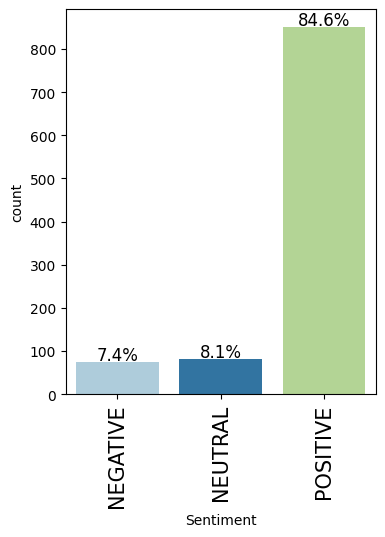

In [12]:
labeled_barplot(data, "Sentiment", perc=True)

- A majority of the reviews are positive (85%), followed by neutral reviews(8%) and negative reviews(7%)

**Defining the model**

In [13]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
#Setting the device to GPU if available, else GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# encoding the dataset
embedding_matrix = model.encode(data['Product Review'], device=device, show_progress_bar=True)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [16]:
# printing the shape of the embedding matrix
embedding_matrix.shape

(1005, 384)

In [17]:
embedding_matrix[0,:]

array([-6.76346421e-02, -2.20813751e-02,  5.92418648e-02,  7.95964450e-02,
        1.31207739e-03, -3.00335735e-02, -4.03319187e-02,  4.49672416e-02,
       -7.75716826e-02,  3.47503200e-02,  4.47142087e-02, -1.00544551e-02,
       -3.18467915e-02,  6.61095902e-02,  1.99794453e-02,  8.67501926e-03,
        4.62192968e-02, -1.06432647e-01, -7.67746046e-02,  8.88167620e-02,
        2.89339889e-02, -6.90294057e-02,  1.93163510e-02, -1.67264175e-02,
       -3.00858505e-02, -4.06527845e-03, -6.03297651e-02, -4.48418967e-02,
       -1.11918822e-02, -4.35903743e-02,  8.26880150e-03,  1.19993001e-01,
       -6.16409145e-02, -9.02840635e-04,  5.56043861e-03, -5.00543155e-02,
        8.40801224e-02, -1.02412462e-01,  6.85360655e-03, -1.57734743e-04,
        6.99327886e-03, -7.78147578e-02, -1.14781046e-02,  7.40694255e-02,
        1.58786308e-02, -5.03668264e-02,  4.27684747e-02,  9.10114944e-02,
       -3.01588066e-02,  3.78680937e-02,  4.32796665e-02, -6.61094412e-02,
        3.48587409e-02, -

# Data Preprocessing

**Splitting the dataset**

In [18]:
X = embedding_matrix
y = data['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [19]:
print(X_train.shape, X_test.shape)

(753, 384) (252, 384)


In [20]:
print(y_train.shape, y_test.shape)

(753,) (252,)


## Model Building - Transformers + ML

In [21]:
# creating a function to plot the confusion matrix
def plot_confusion_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (5, 4))
    label_list = ['Negative', 'Neutral', 'Positive']
    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = label_list, yticklabels = label_list)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [22]:
#Building the model
rf_transformer = RandomForestClassifier(n_estimators=100, random_state=42)

#Fitting on train data
rf_transformer.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
#Predicting on train data
y_pred_train = rf_transformer.predict(X_train)

#Predicting on test data
y_pred_test = rf_transformer.predict(X_test)

Train Data

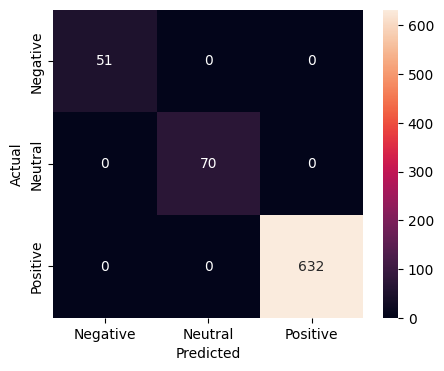

In [24]:
plot_confusion_matrix(y_train, y_pred_train)

In [25]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00        51
     NEUTRAL       1.00      1.00      1.00        70
    POSITIVE       1.00      1.00      1.00       632

    accuracy                           1.00       753
   macro avg       1.00      1.00      1.00       753
weighted avg       1.00      1.00      1.00       753



Test Data

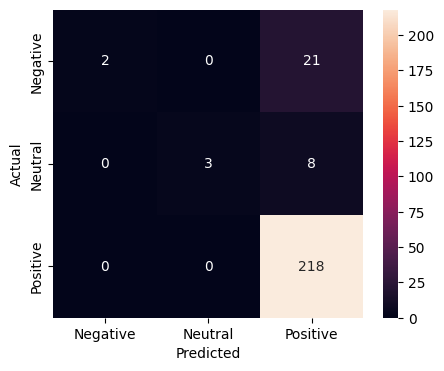

In [26]:
plot_confusion_matrix(y_test, y_pred_test)

In [27]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

    NEGATIVE       1.00      0.09      0.16        23
     NEUTRAL       1.00      0.27      0.43        11
    POSITIVE       0.88      1.00      0.94       218

    accuracy                           0.88       252
   macro avg       0.96      0.45      0.51       252
weighted avg       0.90      0.88      0.84       252



#Model Building - Pre Trained Transformers
DistilBERT

In [28]:
sentiment_hf = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [29]:
trial_data = ["BAd"]
sentiment_hf(trial_data)

[{'label': 'NEGATIVE', 'score': 0.999782383441925}]

In [30]:
hf_review_dict =sentiment_hf(data['Product Review'].to_list(), truncation = True)

In [31]:
hf_review_sent = [0]*len(data['Product Review'])

for product in range(len(data['Product Review'])):
  if hf_review_dict[product]['label'] == 'POSITIVE':
    hf_review_sent[product] = 'POSITIVE'
  elif hf_review_dict[product]['label'] == 'NEUTRAL':
    hf_review_sent[product] = 'NEUTRAL'
  else:
    hf_review_sent[product] = 'NEGATIVE'

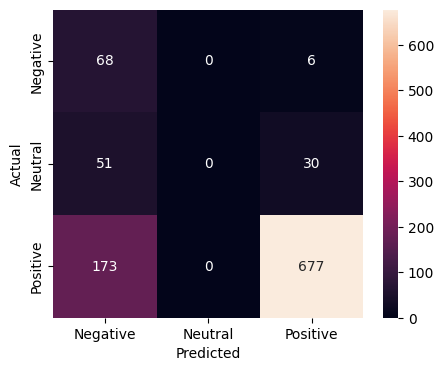

In [32]:
plot_confusion_matrix(y, hf_review_sent)

In [33]:
print(classification_report(y, hf_review_sent))

              precision    recall  f1-score   support

    NEGATIVE       0.23      0.92      0.37        74
     NEUTRAL       0.00      0.00      0.00        81
    POSITIVE       0.95      0.80      0.87       850

    accuracy                           0.74      1005
   macro avg       0.39      0.57      0.41      1005
weighted avg       0.82      0.74      0.76      1005



## **FLAN** T5

In [34]:
X = data['Product Review']
y = data['Sentiment']

In [36]:
#Initializing a T5 tokenizer using the pretrained model
tokenizer = T5Tokenizer.from_pretrained('google/flan-t5-large')

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [37]:
#Initializing a T5 model for conditional generation using the pretrained model 'google/flan-t5-large\
model = T5ForConditionalGeneration.from_pretrained('google/flan-t5-large', load_in_8bit = True, device_map = 'auto')

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [39]:
def generate_responce(prompt):
  input_ids = tokenizer(prompt, return_tensors = 'pt').input_ids.to('cuda')
  outputs = model.generate(input_ids, max_length = 6, do_sample = True, temperature = 0.001)
  return tokenizer.decode(outputs[0])[6:-4]


In [40]:
print('Review:\t', X[4])
print('Actual Sentiment:\t', y[4])

Review:	 I have to say upfront - I don't like coroporate, hermetically closed stuff like anything by Apple or in this case, Amazon. I like having devices on which I can put anything I want and use it. But...I was a fairly happy user of a Nook Touch for several years, but couldn't use all its functionalities since I live in Serbia. Then I lost the Nook and since no other devices can actually be fully used in Serbia (buying books with them, using their online capabilities) except the Kindle, and since no one except Amazon ships to Serbia, and since I've actually been a happy Amazon customer since 2005 over friends' accounts and since 2007 through my own, and since the Kindle definitely has the best technology - why not buy itSo I did. What I read in many reviews about the screen/light of the Paperwhite and similar devices was no problem with mine. The light disperses just fine, except a few black blotches (maybe you can see it in the picture) at the bottom of the screen, which are actual

In [42]:
print('Review:\t', X[214])
print('Actual Sentiment:\t', y[214])

Review:	 very overpriced!
Actual Sentiment:	 NEGATIVE


In [44]:
#Defining a prompt which tells the model what to do
sys_prompt = """
    categorize the sentiment of the review as positive or negative or neutral
    Return NEGATIVE for negative, NEUTRAL for neutral and POSITIVE for positive
    """

#Predicting the sentiment using the model by incorporating the system prompt and the provided review text
pred_sent = generate_responce(
    """
    {}
    Review text: '{}'
    """.format(sys_prompt, X[4])
)

print(pred_sent)

Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


POSITIVE


In [45]:
def predict_sentiment(review_text):
  pred = generate_responce(
      """
      {}
      Review text: '{}'
      """.format(sys_prompt, review_text)
  )
  return pred

In [46]:
#making predictions with model
predicted_sentiment = [predict_sentiment(X[item]) for item in range(len(X))]

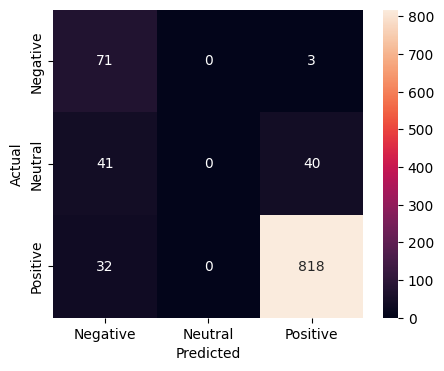

In [47]:
plot_confusion_matrix(y, predicted_sentiment)

In [48]:
print(classification_report(y, predicted_sentiment))

              precision    recall  f1-score   support

    NEGATIVE       0.49      0.96      0.65        74
     NEUTRAL       0.00      0.00      0.00        81
    POSITIVE       0.95      0.96      0.96       850

    accuracy                           0.88      1005
   macro avg       0.48      0.64      0.54      1005
weighted avg       0.84      0.88      0.86      1005

